In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [4]:
### LOAD DATA ###

dataset = 'fashion'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=256)

fashion


In [5]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

In [6]:
### LOAD MODEL ####

model_name = "zeroz"

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_Fashion/FCGenerator2048Fashion_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));

Version 0.4


In [7]:
# Latent z optimization

def genopt(sample_magn, gen, device, init_x=None, steps=5000, lmd=0.0, lr=1.0):
    
    gen.to(device)
    gen.eval()
    
    if init_x is None:
        # TODO: init like PRCGAN
        #z = torch.randn((sample_magn.shape), requires_grad=True, device=device)
        z = torch.zeros(*sample_magn.shape, requires_grad=True, device=device).to(device)
        #z = sample_magn.clone().to(device=device).requires_grad_(True)
    else:
        raise NotImplementedError
    
    opt = optim.Adam([z], lr=lr)
    
    losses = []
    errors = []
    last_out = gen(torch.cat([z, sample_magn], dim=1))
    
    with tqdm(total=steps) as pbar:
        for _ in range(steps):
            magn = calc_mags(last_out)

            error = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            regul = torch.sum(z ** 2)
            loss = torch.sum(error) + lmd * regul

            opt.zero_grad()
            loss.backward()
            opt.step()

            last_out = gen(torch.cat([z, sample_magn], dim=1))

            errors.append(error.detach().cpu().numpy())
            losses.append(loss.item())
            pbar.update()
    
    return last_out.detach().cpu().numpy(), errors

In [64]:
### Latent z optimization ###

num_batches = 4
batch_size = 256
steps = 1
lmd = 0.0
lr = 1.0

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
errors = np.full((batch_size * num_batches, steps), np.inf)

with tqdm(total=num_batches, position=0) as pbar:
    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)
        test_magnitudes = calc_mags(test_sample)   
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
        
        cur_out_results, cur_error = genopt(sample_magn=test_magnitudes, gen=gen, device=device,
                                                      steps=steps, lmd=lmd, lr=lr)

        out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
        errors[batch_size * batch_i : batch_size * batch_i + batch_size] = np.array(cur_error).T

        pbar.update()
        if batch_i + 1 >= num_batches:
            break

In [65]:
### CACHE ERRORS ###

import pickle
pickle.dump(errors, open("../cache/prcgan/Fashion_err-prcgan-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [66]:
### LOAD ERRORS ###
import pickle

errors = pickle.load(open("../cache/prcgan/Fashion_err-prcgan-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

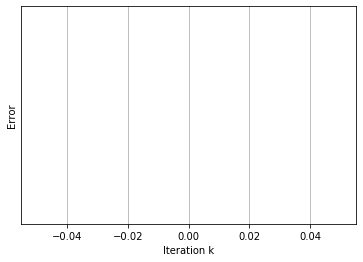

In [67]:
plt.xlabel("Iteration k")
plt.yscale('symlog')
plt.ylabel("Error")
plt.plot(np.mean(errors, axis=0))
plt.grid(which='major')
plt.grid(which='minor')
plt.savefig("../out/plots/prcgan/Fashion_PRCGAN_error-{}-{}s-{}b.png".format(model_name, steps, num_batches), dpi=200)
plt.show()

In [68]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("../cache/prcgan/Fashion_prcgan-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "wb"))
pickle.dump(out_results, open("../cache/prcgan/Fashion_prcgan-{}-{}s-{}b.p".format(model_name, steps, num_batches), "wb"))

In [69]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("../cache/prcgan/Fashion_prcgan-{}-{}s-{}b_original.p".format(model_name, steps, num_batches), "rb"))
out_results = pickle.load(open("../cache/prcgan/Fashion_prcgan-{}-{}s-{}b.p".format(model_name, steps, num_batches), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


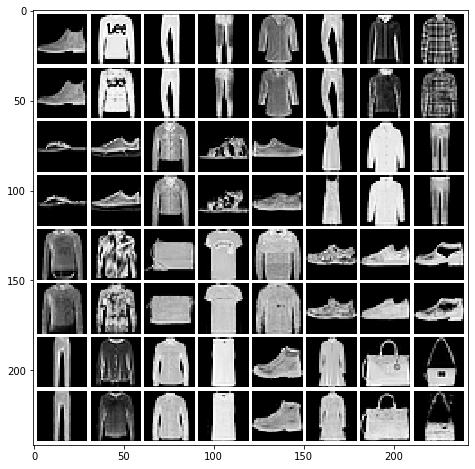

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


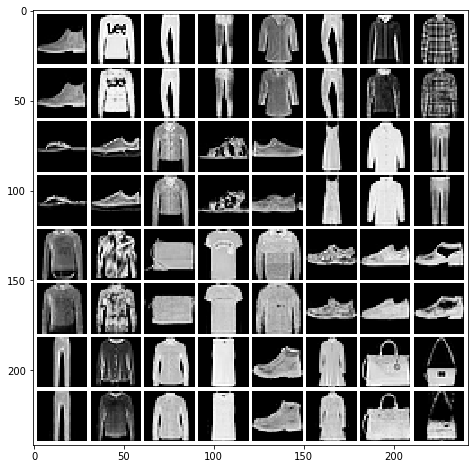

In [70]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8),file="../out/Fashion/generative-prior/prcgan-{}-{}s-{}b.png"\
          .format(model_name, steps, num_batches))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/generative-prior/prcgan-{}-{}s-{}b-reg.png"\
          .format(model_name, steps, num_batches))

In [71]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.016648813320196777, std: 0.017394396145237877
  MAE: 0.05798909096676217, std: 0.03410951644477245
  SSIM: 0.770229076314064, std: 0.16815624105069407
  Sharpness: 0.10820101396973361, std: 0.055766159301523725
  PhCo-MSE: 0.015020644568226452, std: 0.017209700839966754
  PhCo-MAE: 0.056129690075060974, std: 0.03627493145055697
  PhCo-SSIM: 0.7825251786155019, std: 0.17319087859802168
  CroCo-MSE: 0.013207706266529362, std: 0.012491851043860178
  CroCo-MAE: 0.053069186308722816, std: 0.02940793515747658
  CroCo-SSIM: 0.7958719123542126, std: 0.1466140626101356

Magnitude error:
  MSE Magnitude: 2.554939416685488, std: 2.222884169838432

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01665 | 0.05799 | 0.7702 | 0.1082 | 0.01502 | 0.05613 | 0.7825 | 0.01321 | 0.05307 | 0.7959 | 2.555 |


### Random z

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 1.0 | - | 0.01518 | 0.05153 | 0.8044 | 0.08755 | 0.009813 | 0.04299 | 0.8490 | 0.008618 | 0.04118 | 0.8585 | 0.09102 |

Signal error:
  MSE: 0.015184871137652009, std: 0.021083462356645804
  MAE: 0.051526378788537275, std: 0.04282656767164833
  SSIM: 0.8043848553094767, std: 0.2007621643720084
  Sharpness: 0.08754906910886223, std: 0.06683402664387139
  PhCo-MSE: 0.009813269212890594, std: 0.01646309379623924
  PhCo-MAE: 0.04298556063854743, std: 0.0383810791681102
  PhCo-SSIM: 0.8490050762850778, std: 0.1732350595900646
  CroCo-MSE: 0.008617696985886757, std: 0.012754571528974098
  CroCo-MAE: 0.04118017342928605, std: 0.03433089601794571
  CroCo-SSIM: 0.8584911786362291, std: 0.1530903174429491

Magnitude error:
  MSE Magnitude: 0.09101691674452622, std: 0.10096630760635014

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
  
### z = magn

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 1.0 | - | 0.01642 | 0.05387 | 0.7936 | 0.08946 | 0.01039 | 0.04447 | 0.8443 | 0.008836 | 0.04198 | 0.8548 | 0.1254 |

Signal error:
  MSE: 0.016415722035965745, std: 0.022750755474105988
  MAE: 0.053870497276232075, std: 0.04337461403764927
  SSIM: 0.7935595293580676, std: 0.20123678297366798
  Sharpness: 0.08946358857658315, std: 0.0659178976852725
  PhCo-MSE: 0.010392758026035735, std: 0.01811075333265703
  PhCo-MAE: 0.044471860717414706, std: 0.04037625745596505
  PhCo-SSIM: 0.844285237423507, std: 0.17663182383785178
  CroCo-MSE: 0.008836022326168144, std: 0.012730030592421315
  CroCo-MAE: 0.04197997640185622, std: 0.03371844376183678
  CroCo-SSIM: 0.8547566026097604, std: 0.1521106460179387

Magnitude error:
  MSE Magnitude: 0.12544761990411663, std: 0.1337086878470853

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


### z = 0

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.1 | - | 0.01665 | 0.05799 | 0.7702 | 0.1082 | 0.01502 | 0.05613 | 0.7825 | 0.01321 | 0.05307 | 0.7959 | 2.555 |
| 10 | 0.1 | - | 0.01511 | 0.05340 | 0.7937 | 0.09827 | 0.01245 | 0.04978 | 0.8147 | 0.01058 | 0.04682 | 0.8276 | 1.331 |
| 25 | 0.1 | - | 0.01454 | 0.05160 | 0.8031 | 0.09432 | 0.01146 | 0.04703 | 0.8299 | 0.009711 | 0.04440 | 0.8405 | 0.9042 |
| 100 | 0.1 | - | 0.01421 | 0.05022 | 0.8111 | 0.09044 | 0.01026 | 0.04425 | 0.8438 | 0.008930 | 0.04220 | 0.8526 | 0.4784 |
| 500 | 0.1 | - | 0.01432 | 0.05006 | 0.8121 | 0.08856 | 0.009802 | 0.04305 | 0.8486 | 0.008640 | 0.04126 | 0.8576 | 0.2423 |
| 1000 | 0.1 | - | 0.01440 | 0.05012 | 0.8118 | 0.08823 | 0.009660 | 0.04276 | 0.8500 | 0.008594 | 0.04110 | 0.8584 | 0.1856 |
| 2000 | 0.1 | - | 0.01447 | 0.05023 | 0.8111 | 0.08797 | 0.01012 | 0.04327 | 0.8499 | 0.008552 | 0.04102 | 0.8586 | 0.1464 |
| 4000 | 0.1 | - | 0.01453 | 0.05035 | 0.8104 | 0.08775 | 0.01004 | 0.04322 | 0.8504 | 0.008530 | 0.04099 | 0.8585 | 0.1145 |
| 10000 | 1.0 | - | 0.01461 | 0.05056 | 0.8093 | 0.08774 | 0.01015 | 0.04343 | 0.8492 | 0.008536 | 0.04106 | 0.8581 | 0.08345 |

Signal error:
  MSE: 0.014605764507473702, std: 0.02072442711793893
  MAE: 0.050561179264149436, std: 0.04237889187612089
  SSIM: 0.8092567514200242, std: 0.19391744086021165
  Sharpness: 0.08773682101090434, std: 0.06729249460308814
  PhCo-MSE: 0.010147617508737067, std: 0.021173359838621314
  PhCo-MAE: 0.04342871141757235, std: 0.04235043175939238
  PhCo-SSIM: 0.849237785362944, std: 0.17341427228452796
  CroCo-MSE: 0.008536452195785624, std: 0.012882071475979725
  CroCo-MAE: 0.0410582846401905, std: 0.03447206818362784
  CroCo-SSIM: 0.8580933721954157, std: 0.1529896204931895

Magnitude error:
  MSE Magnitude: 0.08345058120617363, std: 0.08909644626838835

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
